<div style="text-align: center;">
  <div style="display: inline-block; min-width: 60%; font-weight: bold; font-size: 24px; color: white; background-color: blue; padding: 15px 20px; border: 2px solid white; border-radius: 8px;">
    Documents Pages Parsing with MonkeyCOR
  </div>
</div>


In this notebook, I'm testing **MonkeyOCR** for document parsing to see how it performs.  
GitHub: [https://github.com/Yuliang-Liu/MonkeyOCR.git](https://github.com/Yuliang-Liu/MonkeyOCR.git)

MonkeyOCR generates several output files:

- **Markdown file (`your.md`)**: Final parsed content with text, formulas, tables, and images.
- **Layout PDF (`your_layout.pdf`)**: Original PDF with visual layout annotations.
- **Intermediate JSON (`your_middle.json`)**: Detailed block data including positions, types, and relationships.
- **Images folder**: Extracted images (e.g., charts, figures, tables) saved separately.

These outputs include both the final formatted content and intermediate details for further analysis.

# **1. Clone the repository**

In [1]:
! git clone https://github.com/Yuliang-Liu/MonkeyOCR.git
%cd MonkeyOCR

Cloning into 'MonkeyOCR'...
remote: Enumerating objects: 448, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 448 (delta 111), reused 97 (delta 93), pack-reused 269 (from 1)
Receiving objects: 100% (448/448), 12.66 MiB | 19.67 MiB/s, done.
Resolving deltas: 100% (216/216), done.
/kaggle/working/MonkeyOCR


In [2]:
! ls

api	 docker       magic_pdf		  README.md	    tools
asserts  docs	      model_configs.yaml  requirements.txt
demo	 LICENSE.txt  parse.py		  setup.py


# **2. Install Pytorch**

In [3]:
%%capture
! pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124 
! pip install -e .

In [4]:
%%capture
! pip install lmdeploy==0.8.0

In [5]:
%%capture
! pip install markdown2
! pip install pdf2image
! apt-get install -y poppler-utils

# **3. Download Model Weights**

In [6]:
%%capture
! pip install huggingface_hub

In [7]:
%%capture
! python tools/download_model.py

# **4. Inference**

In [8]:
import logging
import time
from pathlib import Path
import pandas as pd
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from PIL import Image
import os
import re

from IPython.display import display, HTML
import base64
import markdown
import markdown2

import io
from io import BytesIO, StringIO

import warnings
import sys
import contextlib

In [43]:
def display_text_with_pdf_or_image_plain(markdown_path, file_path, pdf_page=0, max_width=800):
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    with open(markdown_path, "r", encoding="utf-8") as f:
        raw_text = f.read()
    
    # --- Image/PDF Display Part ---
    if file_path.lower().endswith(".pdf"):
        images = convert_from_path(file_path, first_page=pdf_page+1, last_page=pdf_page+1)
        img = images[0].convert("RGB")
    else:
        img = Image.open(file_path).convert("RGB")
    
    w_percent = max_width / float(img.width)
    new_height = int(float(img.height) * w_percent)
    img = img.resize((max_width, new_height), Image.LANCZOS)
    
    buffer = BytesIO()
    img.save(buffer, format="JPEG", quality=70)
    img_data = base64.b64encode(buffer.getvalue()).decode()
    
    html = f"""
    <div style="text-align: center;">
        <img src="data:image/jpeg;base64,{img_data}" style="width: 100%; border: 1px solid #ccc;" />
    </div>
    """
    display(HTML(html))

    # --- Markdown as plain text + tables as DataFrames ---
    html_tables = list(re.finditer(r'(<table[\s\S]*?</table>)', raw_text, re.IGNORECASE))
    last_end = 0
    for match in html_tables:
        text_before = raw_text[last_end:match.start()]
        if text_before.strip():
            print(text_before.strip())
            print('-' * 40)
        table_html = match.group(1)
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", FutureWarning)
                warnings.simplefilter("ignore", RuntimeWarning)
                df_list = pd.read_html(StringIO(table_html))
                for df in df_list:
                    df = df.fillna("")
                    display(df)
        except Exception as e:
            print("Error parsing HTML table:", e)
        last_end = match.end()
    # Print any remaining text after the last table
    if last_end < len(raw_text):
        text_after = raw_text[last_end:].strip()
        if text_after:
            print(text_after)

In [10]:
def display_text_with_pdf_or_image(markdown_path, file_path, pdf_page=0, max_width=800):
    with open(markdown_path, "r", encoding="utf-8") as f:
        raw_text = f.read()

    img_data = None
    if file_path.lower().endswith(".pdf"):
        images = convert_from_path(file_path, first_page=pdf_page+1, last_page=pdf_page+1)
        img = images[0].convert("RGB")
    else:
        img = Image.open(file_path).convert("RGB")

    w_percent = max_width / float(img.width)
    new_height = int(float(img.height) * w_percent)
    img = img.resize((max_width, new_height), Image.LANCZOS)

    buffer = BytesIO()
    img.save(buffer, format="JPEG", quality=70) 
    img_data = base64.b64encode(buffer.getvalue()).decode()

    html = f"""
    <div style="display: flex; gap: 20px;">
        <div style="flex: 1; text-align: center;">
            <img src="data:image/jpeg;base64,{img_data}" style="width: 100%; border: 1px solid #ccc;" />
        </div>
        <pre style="
            flex: 1;
            background-color: #121212;
            color: white;
            padding: 15px;
            border: 1px solid #333;
            overflow-y: auto;
            max-height: 90vh;
            white-space: pre-wrap;
            font-family: 'Courier New', monospace;
        ">
{raw_text}
        </pre>
    </div>
    """
    display(HTML(html))

In [11]:
def display_layout(file_path, max_width=800, quality=70):
    ext = os.path.splitext(file_path)[1].lower()

    try:
        if ext == ".pdf":
            images = convert_from_path(file_path, first_page=1, last_page=1)
            img = images[0].convert("RGB")

        elif ext in [".png", ".jpg", ".jpeg", ".gif", ".bmp", ".webp"]:
            img = Image.open(file_path).convert("RGB")

        else:
            html = f"<p style='color:red;'>Unsupported file type: {ext}</p>"
            display(HTML(html))
            return

        # Resize image (maintain aspect ratio)
        w_percent = max_width / float(img.width)
        new_height = int(float(img.height) * w_percent)
        img = img.resize((max_width, new_height), Image.LANCZOS)

        # Save compressed JPEG image to buffer
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=quality)
        img_data = base64.b64encode(buffer.getvalue()).decode()
        mime = "image/jpeg"

        # HTML display
        html = f"""
        <div style="display: flex; justify-content: center;">
            <img src="data:{mime};base64,{img_data}" 
                 style="max-width: 100%; height: auto; border: 1px solid #ccc;" />
        </div>
        """
        display(HTML(html))

    except Exception as e:
        display(HTML(f"<p style='color:red;'>Error: {e}</p>"))

In [12]:
! python tools/lmdeploy_patcher.py patch

2025-06-22 08:51:21.039 | INFO     | __main__:_find_lmdeploy_path:32 - Found LMDeploy via import: /usr/local/lib/python3.11/dist-packages/lmdeploy
2025-06-22 08:51:21.039 | INFO     | __main__:__init__:22 - Found LMDeploy path: /usr/local/lib/python3.11/dist-packages/lmdeploy
2025-06-22 08:51:21.039 | INFO     | __main__:__init__:23 - Target file: /usr/local/lib/python3.11/dist-packages/lmdeploy/pytorch/kernels/cuda/flashattention.py
2025-06-22 08:51:21.039 | INFO     | __main__:_create_backup:88 - Backup created: /usr/local/lib/python3.11/dist-packages/lmdeploy/pytorch/kernels/cuda/flashattention.py.backup
2025-06-22 08:51:21.040 | INFO     | __main__:patch:146 - Successfully modified file: /usr/local/lib/python3.11/dist-packages/lmdeploy/pytorch/kernels/cuda/flashattention.py
2025-06-22 08:51:21.040 | INFO     | __main__:patch:147 - Added after line 448:     BLOCK_N = min(64, BLOCK_N)
✅ Patch applied successfully


## **Example n°1**

In [13]:
! python parse.py "/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-7.pdf"

2025-06-22 08:51:30.923297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750582291.104033     252 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750582291.157480     252 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading model...
2025-06-22 08:51:42.891 | INFO     | magic_pdf.model.custom_model:__init__:26 - using configs: {'device': 'cuda', 'weights': {'doclayout_yolo': 'Structure/doclayout_yolo_docstructbench_imgsz1280_2501.pt', 'layoutreader': 'Relation'}, 'models_dir': 'model_weight', 'layout_config': {'model': 'doclayout_yolo', 'reader': {'name': 'layoutreader'}}, 'chat_config': {'weight_path': 'model_weight/Recognition', 'backend': 'lmd


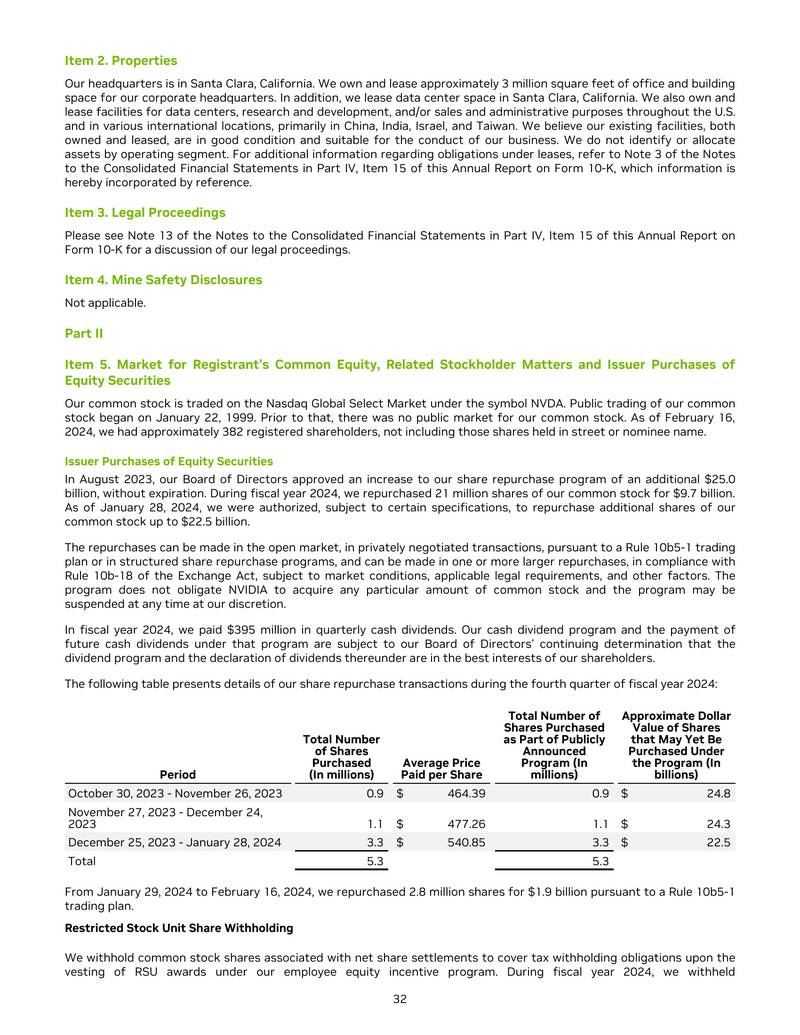

# Item 2. Properties  

Our headquarters is in Santa Clara, California. We own and lease approximately 3 million square feet of office and building space for our corporate headquarters. In addition, we lease data center space in Santa Clara, California. We also own and lease facilities for data centers, research and development, and/or sales and administrative purposes throughout the U.S. and in various international locations, primarily in China, India, Israel, and Taiwan. We believe our existing facilities, both owned and leased, are in good condition and suitable for the conduct of our business. We do not identify or allocate assets by operating segment. For additional information regarding obligations under leases, refer to Note 3 of the Notes to the Consolidated Financial Statements in Part IV, Item 15 of this Annual Report on Form 10-K, which information is hereby incorporated by reference.  

# Item 3. Legal Proceedings  

Please see Note 13 of the Notes to the Consolidated Fina

Period  \
                                  Period   
0   October 30, 2023 - November 26, 2023   
1  November 27, 2023 - December 24, 2023   
2   December 25, 2023 - January 28, 2024   
3                                  Total   

  Total Number of Shares Purchased (In millions)                     \
                              Unnamed: 1_level_1 Unnamed: 2_level_1   
0                                            0.9                  $   
1                                            1.1                  $   
2                                            3.3                  $   
3                                            5.3                5.3   

  Average Price Paid per Share  \
  Average Price Paid per Share   
0                       464.39   
1                       477.26   
2                       540.85   
3                                

  Total Number of Shares Purchased as Part of Publicly Announced Program (In millions)  \
                                                                    Unnamed: 4_level_1   
0                                                0.9                                     
1                                                1.1                                     
2                                                3.3                                     
3                                                5.3                                     

                      \
  Unnamed: 5_level_1   
0                  $   
1                  $   
2                  $   
3                5.3   

  Approximate Dollar Value of Shares that May Yet Be Purchased Under the Program (In billions)  \
  Approximate Dollar Value of Shares that May Yet Be Purchased Under the Program (In billions)   
0                                               24.8                                             
1                                               24.3                                             
2                                               22.5                                             
3                                                                                                

  Unnamed: 7_level_0  
  Unnamed: 7_level_1  
0                     
1                     
2                     
3

</html>  

From January 29, 2024 to February 16, 2024, we repurchased 2.8 million shares for \$1.9 billion pursuant to a Rule 10b5\-1 trading plan.  

# Restricted Stock Unit Share Withholding  

We withhold common stock shares associated with net share settlements to cover tax withholding obligations upon the vesting of RSU awards under our employee equity incentive program. During fiscal year 2024, we withheld


In [44]:
display_text_with_pdf_or_image_plain(
    "./output/NVIDIA_Report_Removed_Pages-1-16-7/NVIDIA_Report_Removed_Pages-1-16-7.md",
    "/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-7.pdf"
)


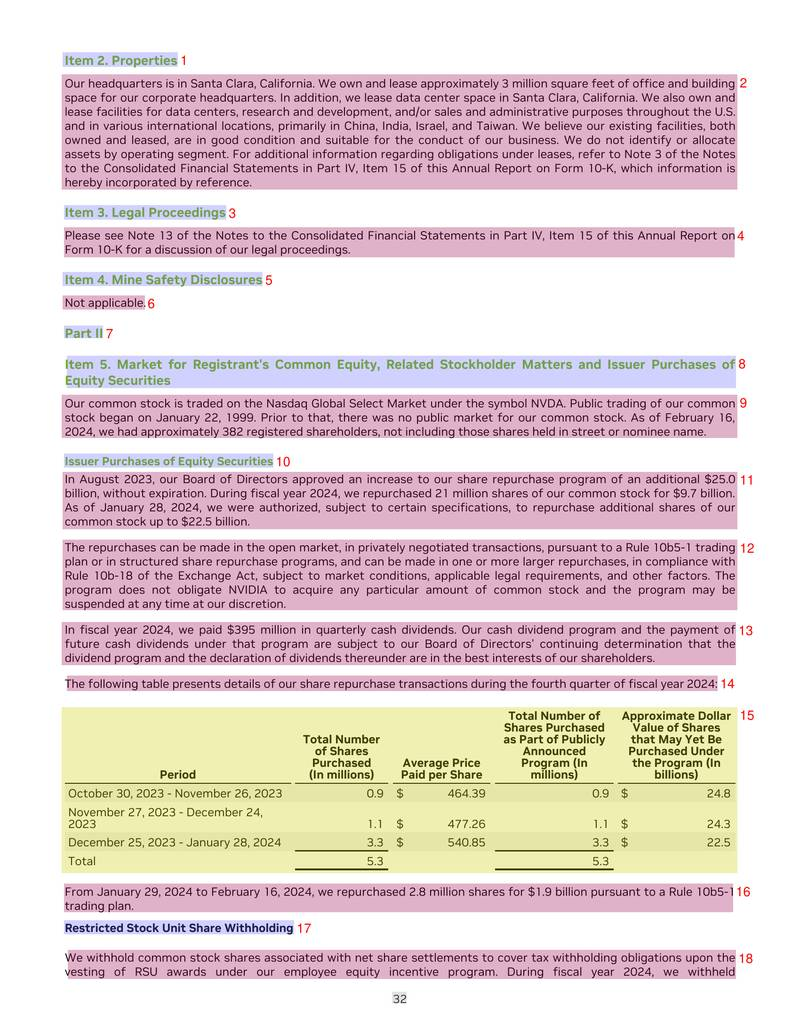

In [15]:
display_layout("./output/NVIDIA_Report_Removed_Pages-1-16-7/NVIDIA_Report_Removed_Pages-1-16-7_layout.pdf")

## **Example n°2**

In [16]:
! python parse.py "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-10.jpg"

2025-06-22 08:52:40.203527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750582360.225940     489 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750582360.233114     489 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading model...
2025-06-22 08:52:43.883 | INFO     | magic_pdf.model.custom_model:__init__:26 - using configs: {'device': 'cuda', 'weights': {'doclayout_yolo': 'Structure/doclayout_yolo_docstructbench_imgsz1280_2501.pt', 'layoutreader': 'Relation'}, 'models_dir': 'model_weight', 'layout_config': {'model': 'doclayout_yolo', 'reader': {'name': 'layoutreader'}}, 'chat_config': {'weight_path': 'model_weight/Recognition', 'backend': 'lmd


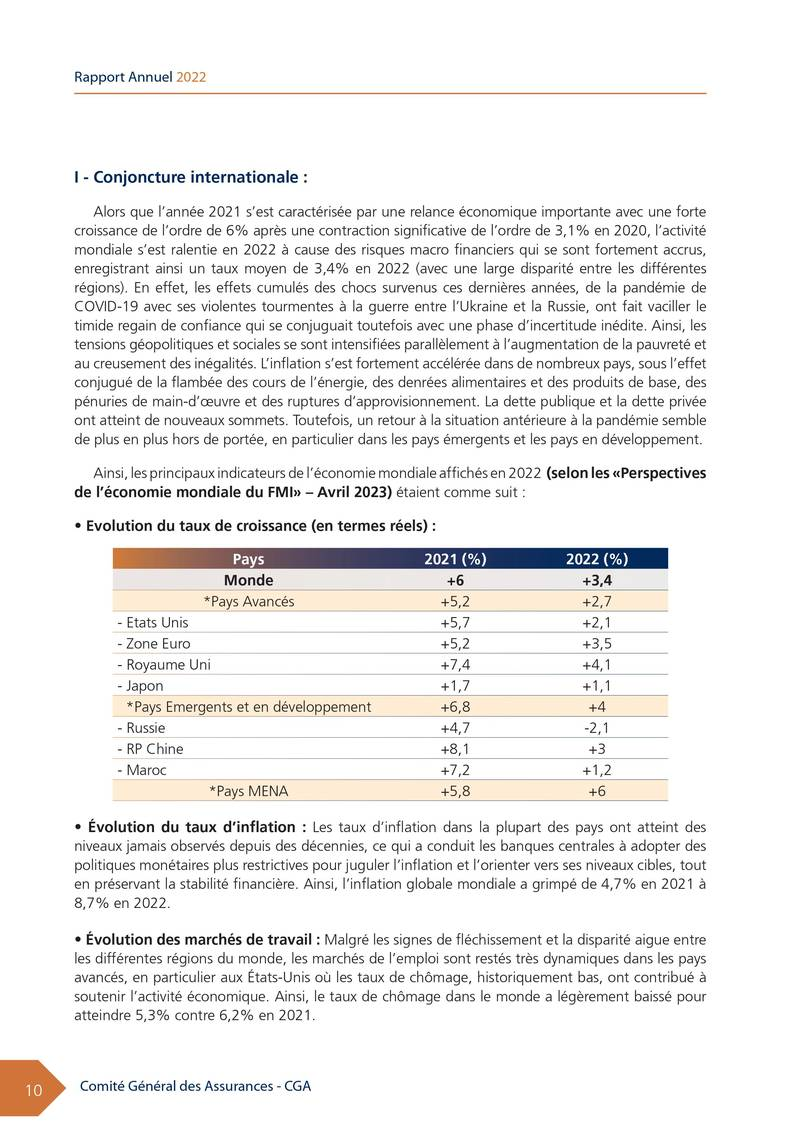

# I - Conjoncture internationale :  

Alors que l'année 2021 s'est caractérisée par une relance économique importante avec une forte croissance de l'ordre de 6% après une contraction significative de l'ordre de 3,1% en 2020, l'activité mondiale s'est ralenti en 2022 à cause des risques macro financiers qui se sont fortement accrus, enregistrant ainsi un taux moyen de 3,4% en 2022 (avec une large disparité entre les différentes régions). En effet, les effets cumulés des chocs survenus ces dernières années, de la pandémie de COVID-19 avec ses violentes tourmentes à la guerre entre l'Ukraine et la Russie, ont fait vaciller le timide regain de confiance qui se conjuguait toutefois avec une phase d'incertitude inédite. Ainsi, les tensions géopolitiques et sociales se sont intensifiées parallèlement à l'augmentation de la pauvreté et au creusement des inégalités. L'inflation s'est fortement accélérée dans de nombreux pays, sous l'effet conjugué de la flambée des cours de l'énergie, des denré

,Pays,2021 (%),2022 (%)
0,Monde,6,34
1,*Pays Avancés,52,27
2,- Etats Unis,57,21
3,- Zone Euro,52,35
4,- Royaume Uni,74,41
5,- Japon,17,11
6,*Pays Emergents et en développement,68,4
7,- Russie,47,-21
8,- RP Chine,81,3
9,- Maroc,72,12


</html>  

- Évolution du taux d'inflation : Les taux d'inflation dans la plupart des pays ont atteint des niveaux jamais observés depuis des décennies, ce qui a conduit les banques centrales à adopter des politiques monétaires plus restrictives pour juguler l'inflation et l'orienter vers ses niveaux cibles, tout en préservant la stabilité financière. Ainsi, l'inflation globale mondiale a grimpé de 4,7% en 2021 à 8,7% en 2022.  

- Évolution des marchés de travail : Malgré les signes de fléchissement et la disparité aigue entre les différentes régions du monde, les marchés de l'emploi sont restés très dynamiques dans les pays avancés, en particulier aux États-Unis où les taux de chômage, historiquement bas, ont contribué à soutenir l'activité économique. Ainsi, le taux de chômage dans le monde a légèrement baissé pour atteindre 5,3% contre 6,2% en 2021.


In [45]:
display_text_with_pdf_or_image_plain(
    "./output/RAP_CGA_FR_ANG_2022-images-10/RAP_CGA_FR_ANG_2022-images-10.md", 
    "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-10.jpg"
)


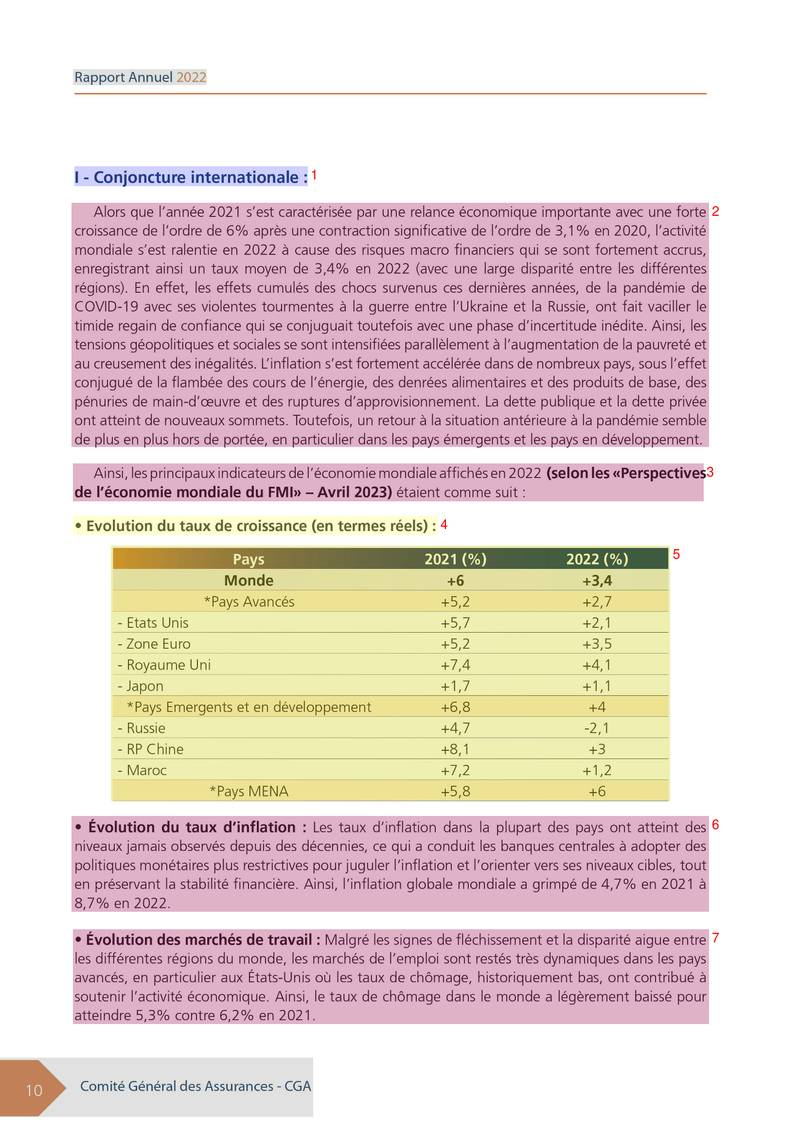

In [18]:
display_layout("./output/RAP_CGA_FR_ANG_2022-images-10/RAP_CGA_FR_ANG_2022-images-10_layout.pdf")

## **Example n°3**

In [19]:
! python parse.py "/kaggle/input/different-tables-images-testing/NVIDIA_Report_Removed_Pages-1-16-14_page-0001.jpg"

2025-06-22 08:53:26.092694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750582406.114709     521 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750582406.121395     521 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading model...
2025-06-22 08:53:29.761 | INFO     | magic_pdf.model.custom_model:__init__:26 - using configs: {'device': 'cuda', 'weights': {'doclayout_yolo': 'Structure/doclayout_yolo_docstructbench_imgsz1280_2501.pt', 'layoutreader': 'Relation'}, 'models_dir': 'model_weight', 'layout_config': {'model': 'doclayout_yolo', 'reader': {'name': 'layoutreader'}}, 'chat_config': {'weight_path': 'model_weight/Recognition', 'backend': 'lmd


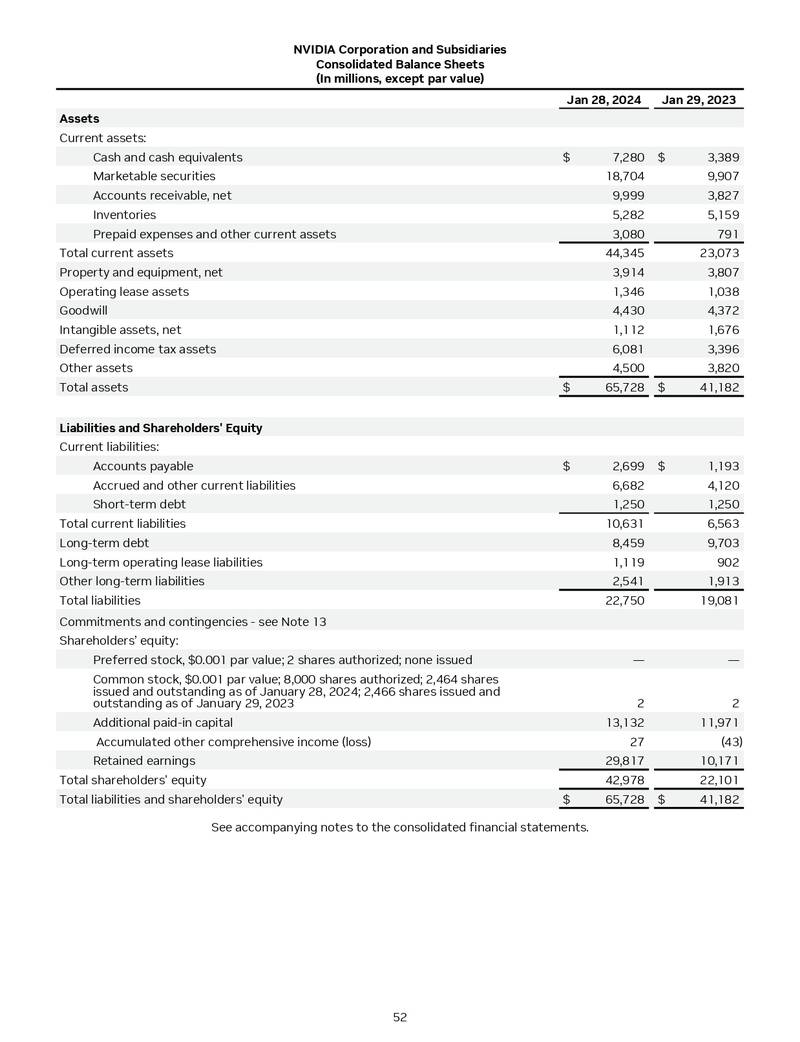

<html>
----------------------------------------


Unnamed: 0_level_0                               Jan 28, 2024  \
                         Assets                         Unnamed: 1_level_1   
0               Current assets:                                              
1                                                Cash and cash equivalents   
2                                                    Marketable securities   
3                                                 Accounts receivable, net   
4                                                              Inventories   
5                                Prepaid expenses and other current assets   
6          Total current assets                                              
7   Property and equipment, net                                              
8        Operating lease assets                                              
9                      Goodwill                                              
10       Intangible assets, net                                              
11   Deferred income tax assets                                              
12                 Other assets                                              
13                 Total assets                                          $   

                            Jan 29, 2023                    Unnamed: 5_level_0  
   Unnamed: 2_level_1 Unnamed: 3_level_1 Unnamed: 4_level_1 Unnamed: 5_level_1  
0                                                                               
1                   $               7280                  $             3389.0  
2                                  18704                                9907.0  
3                                   9999                                3827.0  
4                                   5282                                5159.0  
5                                   3080                                 791.0  
6                                  44345                               23073.0  
7                                   3914                                3807.0  
8                                   1346                                1038.0  
9                                   4430                                4372.0  
10                                  1112                                1676.0  
11                                  6081                                3396.0  
12                                  4500                                3820.0  
13              65728                  $              41182

</html>  

<html>
----------------------------------------


,Current liabilities:,Unnamed: 1_level_0,Unnamed: 2_level_0,Unnamed: 3_level_0,Unnamed: 4_level_0
,Accounts payable,$,"2,699",$,"1,193"
,Accrued and other current liabilities,Unnamed: 1_level_2,"6,682",Unnamed: 3_level_2,"4,120"
,Short-term debt,Unnamed: 1_level_3,"1,250",Unnamed: 3_level_3,"1,250"
0,Total current liabilities,,10631.0,,6563
1,Long-term debt,,8459.0,,9703
2,Long-term operating lease liabilities,,1119.0,,902
3,Other long-term liabilities,,2541.0,,1913
4,Total liabilities,,22750.0,,19081
5,Commitments and contingencies - see Note 13,,,,
6,Shareholders’ equity:,,,,


</html>

See accompanying notes to the consolidated financial statements.


In [46]:
display_text_with_pdf_or_image_plain(
    "./output/NVIDIA_Report_Removed_Pages-1-16-14_page-0001/NVIDIA_Report_Removed_Pages-1-16-14_page-0001.md", 
    "/kaggle/input/different-tables-images-testing/NVIDIA_Report_Removed_Pages-1-16-14_page-0001.jpg"
)


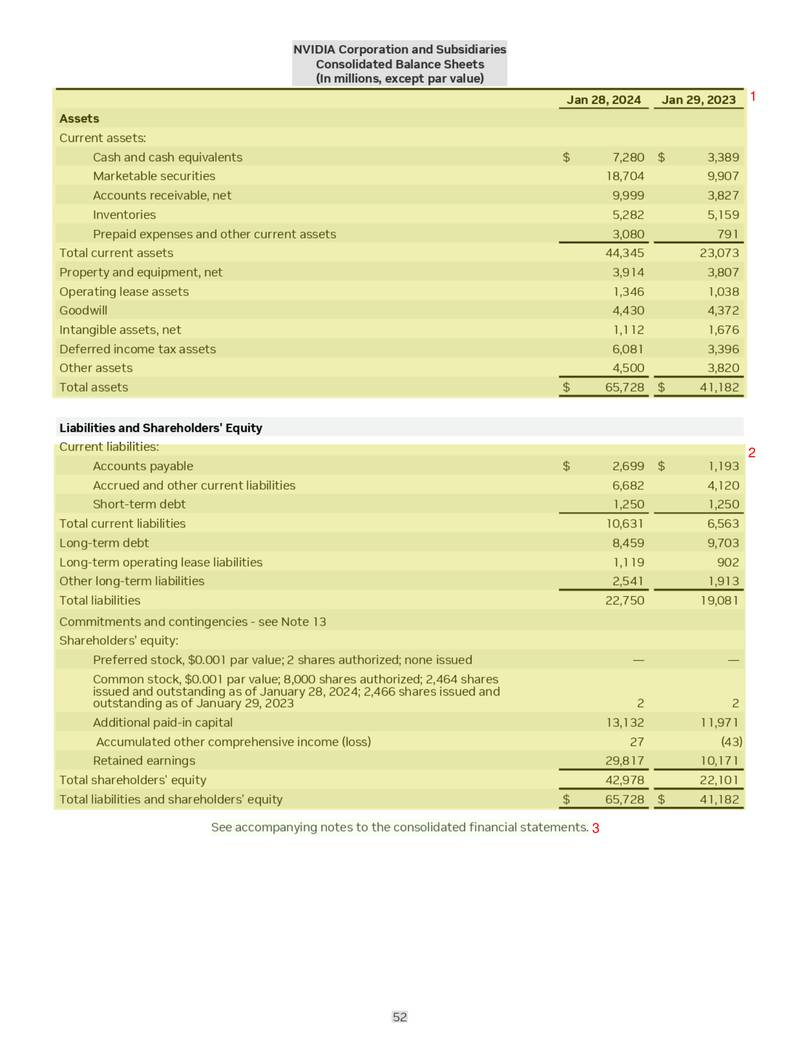

In [21]:
display_layout("./output/NVIDIA_Report_Removed_Pages-1-16-14_page-0001/NVIDIA_Report_Removed_Pages-1-16-14_page-0001_layout.pdf")

## **Example n°4**

In [25]:
! python parse.py "/kaggle/input/different-tables-images-testing/other_table_big.jpg"

2025-06-22 09:01:59.462006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750582919.485203     584 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750582919.491982     584 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading model...
2025-06-22 09:02:03.142 | INFO     | magic_pdf.model.custom_model:__init__:26 - using configs: {'device': 'cuda', 'weights': {'doclayout_yolo': 'Structure/doclayout_yolo_docstructbench_imgsz1280_2501.pt', 'layoutreader': 'Relation'}, 'models_dir': 'model_weight', 'layout_config': {'model': 'doclayout_yolo', 'reader': {'name': 'layoutreader'}}, 'chat_config': {'weight_path': 'model_weight/Recognition', 'backend': 'lmd


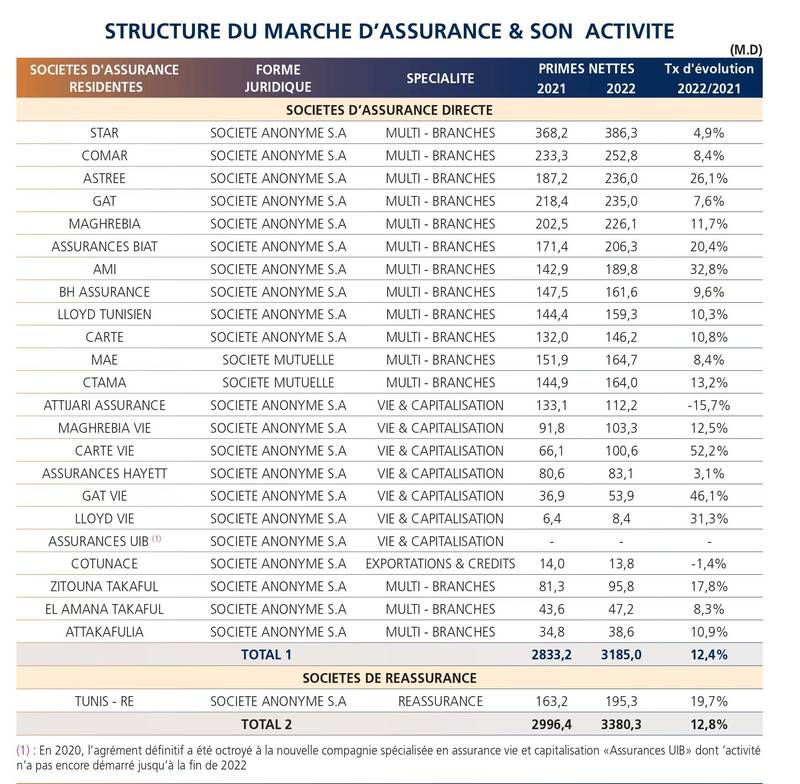

STRUCTURE DU MARCHE D'ASSURANCE & SON ACTIVITE   


<html>
----------------------------------------


Societes d'assurance residentes               Forme juridique  \
   Societes d'assurance residentes               Forme juridique   
0     Societes d'assurance directe  Societes d'assurance directe   
1                             STAR           SOCIETE ANONYME S.A   
2                            COMAR           SOCIETE ANONYME S.A   
3                           ASTREE           SOCIETE ANONYME S.A   
4                              GAT           SOCIETE ANONYME S.A   
5                        MAGHREBIA           SOCIETE ANONYME S.A   
6                  ASSURANCES BIAT           SOCIETE ANONYME S.A   
7                              AMI           SOCIETE ANONYME S.A   
8                     BH ASSURANCE           SOCIETE ANONYME S.A   
9                   LLOYD TUNISIEN           SOCIETE ANONYME S.A   
10                           CARTE           SOCIETE ANONYME S.A   
11                             MAE              SOCIETE MUTUELLE   
12                           CTAMA              SOCIETE MUTUELLE   
13              ATTIJARI ASSURANCE           SOCIETE ANONYME S.A   
14                   MAGHREBIA VIE           SOCIETE ANONYME S.A   
15                       CARTE VIE           SOCIETE ANONYME S.A   
16               ASSURANCES HAYETT           SOCIETE ANONYME S.A   
17                         GAT VIE           SOCIETE ANONYME S.A   
18                       LLOYD VIE           SOCIETE ANONYME S.A   
19              ASSURANCES UIB (1)           SOCIETE ANONYME S.A   
20                        COTUNACE           SOCIETE ANONYME S.A   
21                 ZITOUNA TAKAFUL           SOCIETE ANONYME S.A   
22                EL AMANA TAKAFUL           SOCIETE ANONYME S.A   
23                     ATTAKAFULIA           SOCIETE ANONYME S.A   
24                                                       Total 1   
25         Societes de reinsurance       Societes de reinsurance   
26                      TUNIS - RE           SOCIETE ANONYME S.A   
27                                                       Total 2   

                      Specialite                 Primes nettes  \
                      Specialite                          2021   
0   Societes d'assurance directe  Societes d'assurance directe   
1               MULTI - BRANCHES                          3682   
2               MULTI - BRANCHES                          2333   
3               MULTI - BRANCHES                          1872   
4               MULTI - BRANCHES                          2184   
5               MULTI - BRANCHES                          2025   
6               MULTI - BRANCHES                          1714   
7               MULTI - BRANCHES                          1429   
8               MULTI - BRANCHES                          1475   
9               MULTI - BRANCHES                          1444   
10              MULTI - BRANCHES                          1320   
11              MULTI - BRANCHES                          1519   
12              MULTI - BRANCHES                          1449   
13          VIE & CAPITALISATION                          1331   
14          VIE & CAPITALISATION                           918   
15          VIE & CAPITALISATION                           661   
16          VIE & CAPITALISATION                           806   
17          VIE & CAPITALISATION                           369   
18          VIE & CAPITALISATION                            64   
19          VIE & CAPITALISATION                             -   
20        EXPORTATIONS & CREDITS                           140   
21              MULTI - BRANCHES                           813   
22              MULTI - BRANCHES                           436   
23              MULTI - BRANCHES                           348   
24                                                       28332   
25       Societes de reinsurance       Societes de reinsurance   
26                   REASSURANCE                          1632   
27                                              

</html>

(1) : En 2020, l'agrément définitif a été octroyé à la nouvelle compagnie spécialisée en assurance vie et capitalisation «Assurances UIB» dont 'activité n'a pas encore démarré jusqu'à la fin de 2022


In [47]:
display_text_with_pdf_or_image_plain(
    "./output/other_table_big/other_table_big.md", 
    "/kaggle/input/different-tables-images-testing/other_table_big.jpg"
)


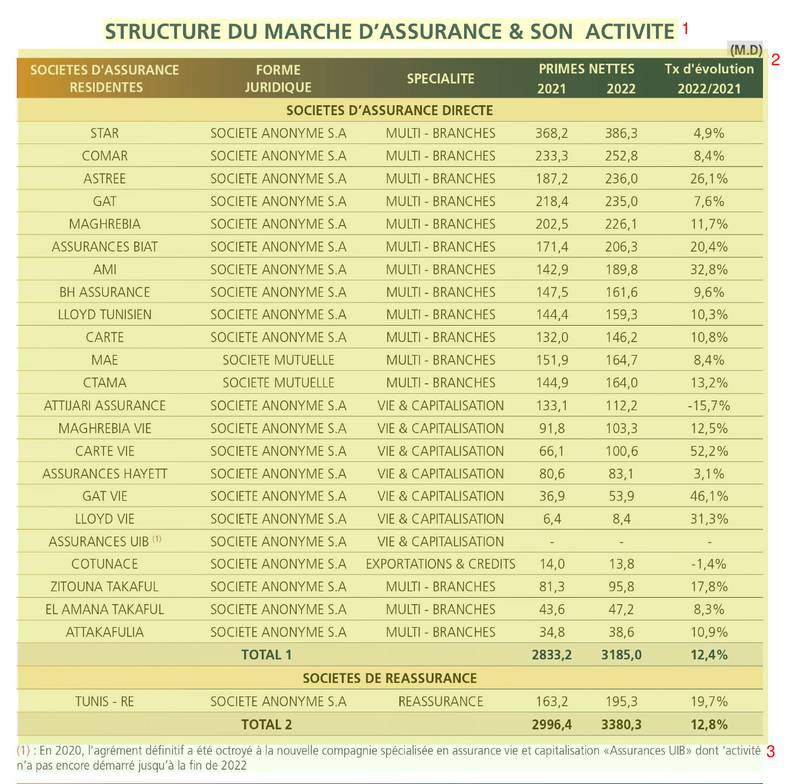

In [27]:
display_layout("./output/other_table_big/other_table_big_layout.pdf")

## **Example n°5**

In [28]:
! python parse.py "/kaggle/input/different-tables-images-testing/table_3.jpg"

2025-06-22 09:05:17.193618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750583117.216853     615 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750583117.223683     615 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading model...
2025-06-22 09:05:20.895 | INFO     | magic_pdf.model.custom_model:__init__:26 - using configs: {'device': 'cuda', 'weights': {'doclayout_yolo': 'Structure/doclayout_yolo_docstructbench_imgsz1280_2501.pt', 'layoutreader': 'Relation'}, 'models_dir': 'model_weight', 'layout_config': {'model': 'doclayout_yolo', 'reader': {'name': 'layoutreader'}}, 'chat_config': {'weight_path': 'model_weight/Recognition', 'backend': 'lmd


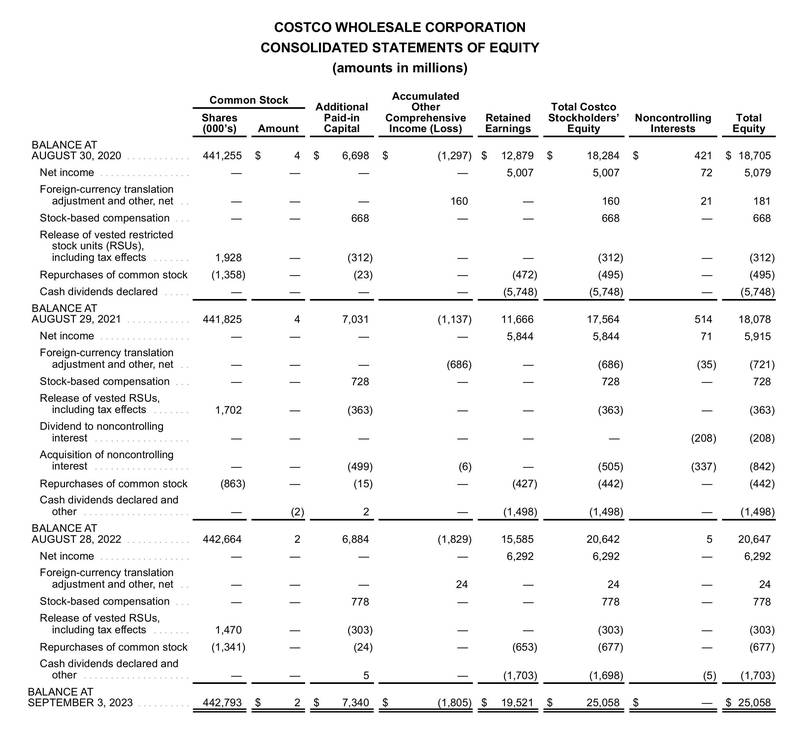

COSTCO WHOLESALE CORPORATION
CONSOLIDATED STATEMENTS OF EQUITY
(amounts in millions)   


<html>
----------------------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,(amounts in millions),(amounts in millions),(amounts in millions),(amounts in millions),(amounts in millions),(amounts in millions),(amounts in millions),(amounts in millions),(amounts in millions),(amounts in millions),(amounts in millions),(amounts in millions),(amounts in millions),(amounts in millions),
1,,Common Stock,Common Stock,Additional Paid-in Capital,Additional Paid-in Capital,Accumulated Other Comprehensive Income (Loss),Accumulated Other Comprehensive Income (Loss),Retained Earnings,Retained Earnings,Total Costco Stockholders'Equity,Total Costco Stockholders'Equity,Noncontrolling Interests,Noncontrolling Interests,Total Equity,Total Equity
2,,Shares (000's),Amount,$,6698,$,"(1,297)",$,12879,$,18284,$,421,"$18,705",
3,"BALANCE AT AUGUST 30, 2020",441255,$,4,6698,$,"(1,297)",$,12879,$,18284,$,421,"$18,705",
4,Net income,,,,,,,,5007,,5007,,72,5079,
5,Foreign-currency translation adjustment and ot...,,,,,,160,,,,160,,21,181,
6,Stock-based compensation,,,,668,,,,,,668,,,668,
7,Release of vested restricted stock units (RSUs...,1928,,,(312),,,,,(312),,,,(312),
8,Repurchases of common stock,"(1,358)",,,(23),,,,(472),,(495),,,(495),
9,Cash dividends declared,,,,,,,,"(5,748)",,"(5,748)",,,"(5,748)",


</html>


In [48]:
display_text_with_pdf_or_image_plain(
    "./output/table_3/table_3.md", 
    "/kaggle/input/different-tables-images-testing/table_3.jpg"
)


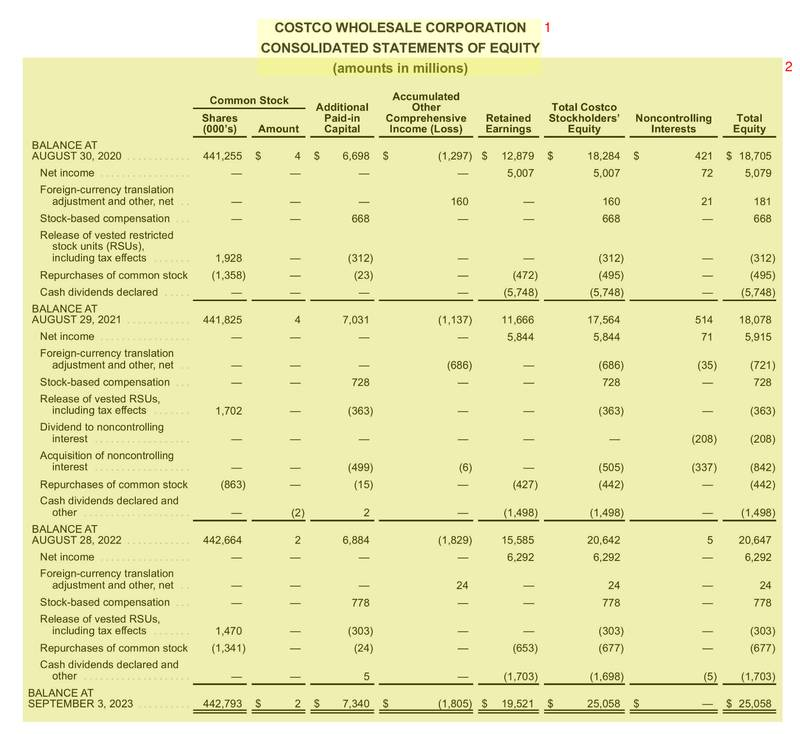

In [30]:
display_layout("./output/table_3/table_3_layout.pdf")

## **Example n°6**

In [31]:
! python parse.py "/kaggle/input/pdf-files-pages/Marriott International Reports Third Quarter 2024 Results_page-0011.jpg"

2025-06-22 09:10:35.725780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750583435.752899     648 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750583435.761562     648 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading model...
2025-06-22 09:10:39.531 | INFO     | magic_pdf.model.custom_model:__init__:26 - using configs: {'device': 'cuda', 'weights': {'doclayout_yolo': 'Structure/doclayout_yolo_docstructbench_imgsz1280_2501.pt', 'layoutreader': 'Relation'}, 'models_dir': 'model_weight', 'layout_config': {'model': 'doclayout_yolo', 'reader': {'name': 'layoutreader'}}, 'chat_config': {'weight_path': 'model_weight/Recognition', 'backend': 'lmd

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.



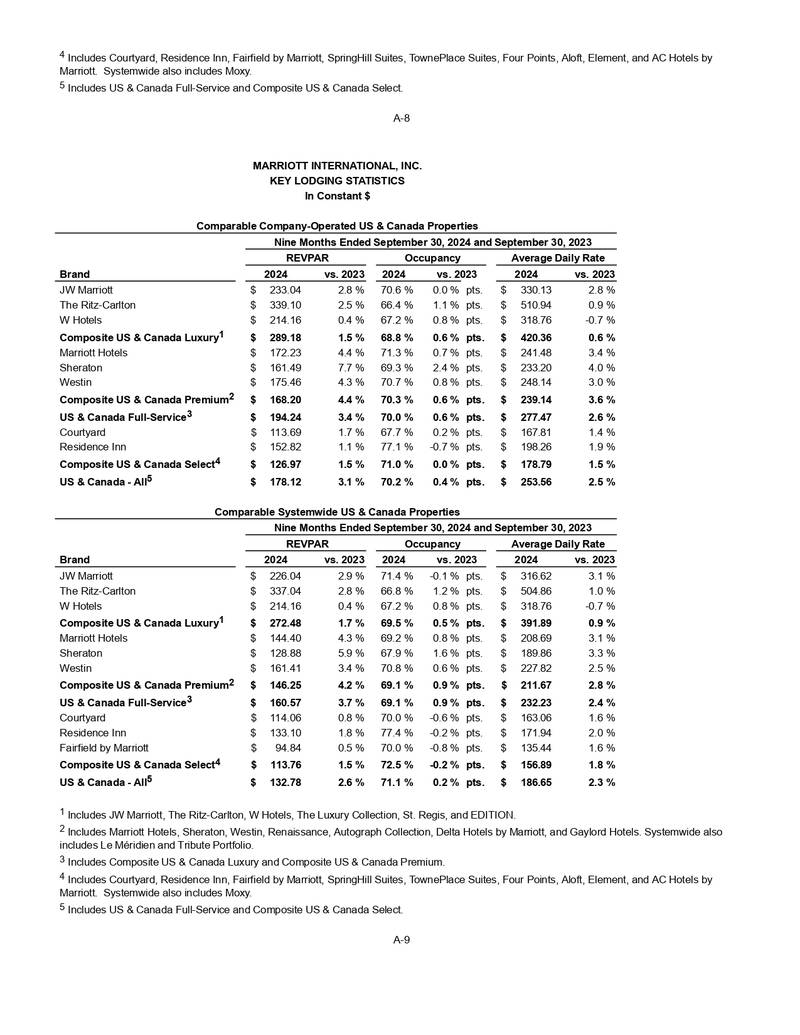

<html>
----------------------------------------


,0,1,2,3,4,5,6,7,8
0,Comparable Company-Operated US & Canada Proper...,Comparable Company-Operated US & Canada Proper...,Comparable Company-Operated US & Canada Proper...,Comparable Company-Operated US & Canada Proper...,Comparable Company-Operated US & Canada Proper...,Comparable Company-Operated US & Canada Proper...,Comparable Company-Operated US & Canada Proper...,,
1,"Nine Months Ended September 30, 2024 and Septe...","Nine Months Ended September 30, 2024 and Septe...","Nine Months Ended September 30, 2024 and Septe...","Nine Months Ended September 30, 2024 and Septe...","Nine Months Ended September 30, 2024 and Septe...","Nine Months Ended September 30, 2024 and Septe...","Nine Months Ended September 30, 2024 and Septe...",,
2,,REVPAR,REVPAR,Occupancy,Occupancy,Average Daily Rate,Average Daily Rate,,
3,,2024,2024,vs. 2023,vs. 2023,2024,2024,vs. 2023,vs. 2023
4,JW Marriott,$233.04,2.8%,70.6%,0.0%pts.,$330.13,2.8%,,
5,The Ritz-Carlton,$339.10,2.5%,66.4%,1.1%pts.,$510.94,0.9%,,
6,W Hotels,$214.16,0.4%,67.2%,0.8%pts.,$318.76,-0.7%,,
7,Composite US & Canada Luxury $^1$,$289.18,1.5%,68.8%,0.6%pts.,$420.36,0.6%,,
8,Marriott Hotels,$172.23,4.4%,71.3%,0.7%pts.,$241.48,3.4%,,
9,Sheraton,$161.49,7.7%,69.3%,2.4%pts.,$233.20,4.0%,,


</html>

1 Includes JW Marriott, The Ritz-Carlton, W Hotels, The Luxury Collection, St. Regis, and EDITION. 2 Includes Marriott Hotels, Sheraton, Westin, Renaissance, Autograph Collection, Delta Hotels by Marriott, and Gaylord Hotels. Systemwide also includes Le Méridien and Tribute Portfolio. 3 Includes Composite US & Canada Luxury and Composite US & Canada Premium. 4 Includes Courtyard, Residence Inn, Fairfield by Marriott, SpringHill Suites, TownePlace Suites, Four Points, Aloft, Element, and AC Hotels by Marriott. Systemwide also includes Moxy. 5 Includes US & Canada Full-Service and Composite US & Canada Select.


In [49]:
display_text_with_pdf_or_image_plain(
    "./output/Marriott International Reports Third Quarter 2024 Results_page-0011/Marriott International Reports Third Quarter 2024 Results_page-0011.md", 
    "/kaggle/input/pdf-files-pages/Marriott International Reports Third Quarter 2024 Results_page-0011.jpg"
)


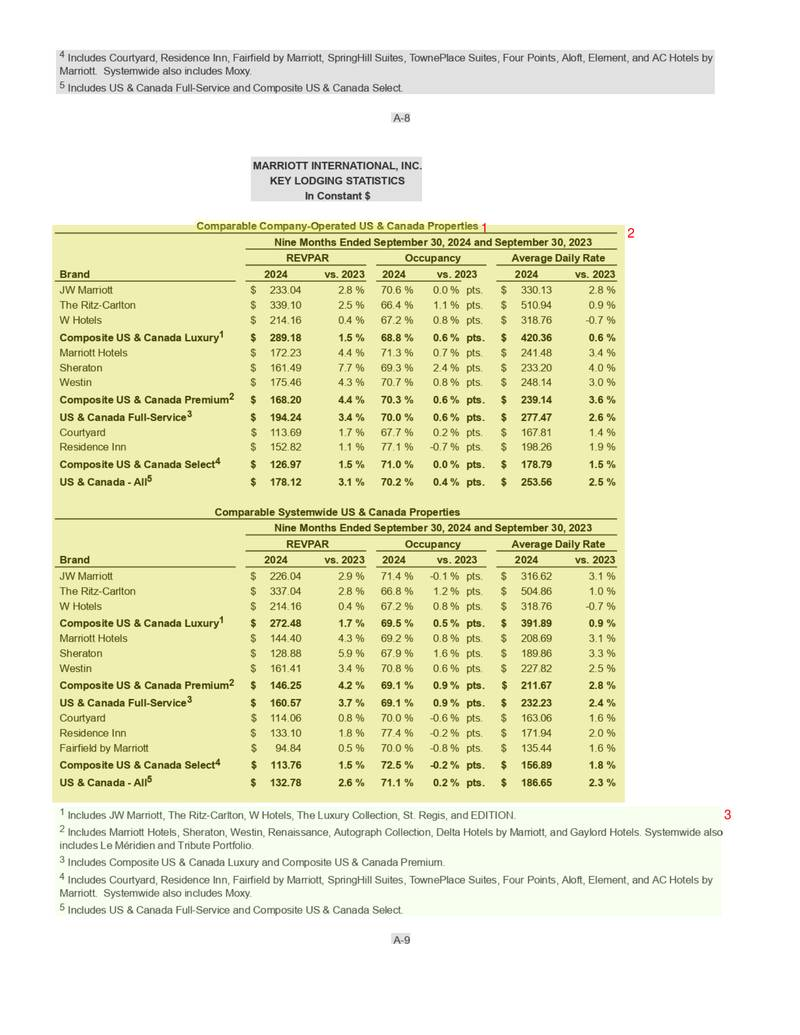

In [33]:
display_layout("./output/Marriott International Reports Third Quarter 2024 Results_page-0011/Marriott International Reports Third Quarter 2024 Results_page-0011_layout.pdf")

## **Example n°7**

In [34]:
! python parse.py "/kaggle/input/pdf-files-pages/RHG_annual_report_2022_page-0047.pdf"

2025-06-22 09:13:57.745576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750583637.769591     681 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750583637.776635     681 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading model...
2025-06-22 09:14:01.539 | INFO     | magic_pdf.model.custom_model:__init__:26 - using configs: {'device': 'cuda', 'weights': {'doclayout_yolo': 'Structure/doclayout_yolo_docstructbench_imgsz1280_2501.pt', 'layoutreader': 'Relation'}, 'models_dir': 'model_weight', 'layout_config': {'model': 'doclayout_yolo', 'reader': {'name': 'layoutreader'}}, 'chat_config': {'weight_path': 'model_weight/Recognition', 'backend': 'lmd


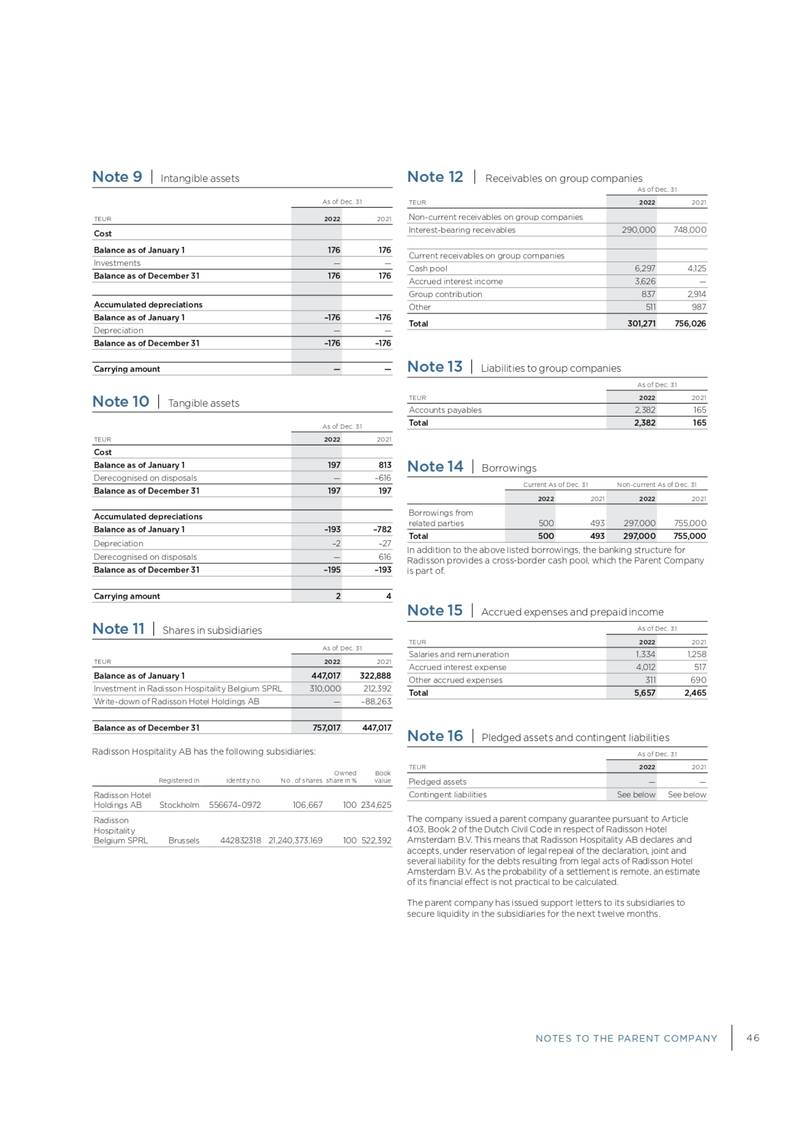

Note 9 | Intangible assets   


<html>
----------------------------------------


,0,1,2
0,,As of Dec.31,As of Dec.31
1,TEUR,2022,2021
2,Cost,,
3,Balance as of January 1,176,176
4,Investments,,
5,Balance as of December 31,176,176
6,,,
7,Accumulateddepreciations,,
8,Balance as of January 1,-176,-176
9,Depreciation,,


</html>  

# Note 10 | Tangible assets  

# Note 11 | Shares in subsidiaries  

<html>
----------------------------------------


,0,1,2
0,,As of Dec.31,As of Dec.31
1,TEUR,2022,2021
2,Balance as of January 1,447017,322888
3,Investment in Radisson Hospitality Belgium SPRL,310000,212392
4,Write-down of Radisson Hotel Holdings AB,,-88263
5,,,
6,Balance as of December 31,757017,447017
7,,,


</html>  

Radisson Hospitality AB has the following subsidiaries:   


<html>
----------------------------------------


,0,1,2,3,4,5
0,,Registered in,Identity no.,No. of shares,Owned share in %,Book value
1,Radisson Hotel Holdings AB,Stockholm,556674-0972,106667,100,234625
2,Radisson Hospitality Belgium SPRL,Brussels,442832318,21240373169,100,522392
3,,,,,,


</html>  

Note 12 | Receivables on group companies As of Dec. 31   


<html>
----------------------------------------


,0,1,2,3,4
0,TEUR,TEUR,TEUR,2022.0,2021.0
1,Non-current receivables on group companies,Non-current receivables on group companies,Non-current receivables on group companies,,
2,Interest-bearing receivables,Interest-bearing receivables,Interest-bearing receivables,290000.0,748000.0
3,,,,,
4,Current receivables on group companies,Current receivables on group companies,Current receivables on group companies,,
5,Cash pool,Cash pool,Cash pool,6297.0,4125.0
6,Accrued interest income,Accrued interest income,Accrued interest income,3626.0,
7,Group contribution,Group contribution,Group contribution,837.0,2914.0
8,Other,Other,Other,511.0,987.0
9,Total,Total,Total,301271.0,756026.0


</html>  

Note 13 | Liabilities to group companies   


<html>
----------------------------------------


,0,1,2,3
0,,As of Dec.31,As of Dec.31,
1,TEUR,TEUR,2022,2021.0
2,Accounts payables,Accounts payables,2382,165.0
3,Total,Total,2382,165.0
4,,,,


</html>  

Note 14 | Borrowings   


<html>
----------------------------------------


Unnamed: 0_level_0 As of December 31,       
                              EUR               2022   2021
0                            Cost                          
1         Balance as of January 1                197  813.0
2   Depreciation and amortization                  — -616.0
3       Balance as of December 31                197  197.0
4                                                          
5        Accumulated depreciation                          
6         Balance as of January 1               -193 -782.0
7                    Depreciation                 -2  -27.0
8   Depreciation and amortization                  —  616.0
9       Balance as of December 31               -195 -193.0
10                                                         
11                Carrying amount                  2    4.0
12

</html>

In addition to the above listed borrowings, the banking structure for Radisson provides a cross-border cash pool, which the Parent Company is part of.  

Note 15 | Accrued expenses and prepaid income   


<html>
----------------------------------------


,0,1,2
0,,As of Dec.31,As of Dec.31
1,TEUR,2022,2021
2,Salaries and remuneration,1334,1258
3,Accrued interest expense,4012,517
4,Other accrued expenses,311,690
5,Total,5657,2465
6,,,


</html>  

Note 16 | Pledged assets and contingent liabilities   


<html>
----------------------------------------


,0,1,2
0,,As of Dec.31,As of Dec.31
1,TEUR,2022,2021
2,Pledged assets,—,—
3,Contingent liabilities,See below,See below
4,,,


</html>  

The company issued a parent company guarantee pursuant to Article 403, Book 2 of the Dutch Civil Code in respect of Radisson Hotel Amsterdam B.V. This means that Radisson Hospitality AB declares and accepts, under reservation of legal repeal of the declaration, joint and several liability for the debts resulting from legal acts of Radisson Hotel Amsterdam B.V. As the probability of a settlement is remote, an estimate of its financial effect is not practical to be calculated.  

The parent company has issued support letters to its subsidiaries to secure liquidity in the subsidiaries for the next twelve months.


In [50]:
display_text_with_pdf_or_image_plain(
    "./output/RHG_annual_report_2022_page-0047/RHG_annual_report_2022_page-0047.md", 
    "/kaggle/input/pdf-files-pages/RHG_annual_report_2022_page-0047.pdf"
)


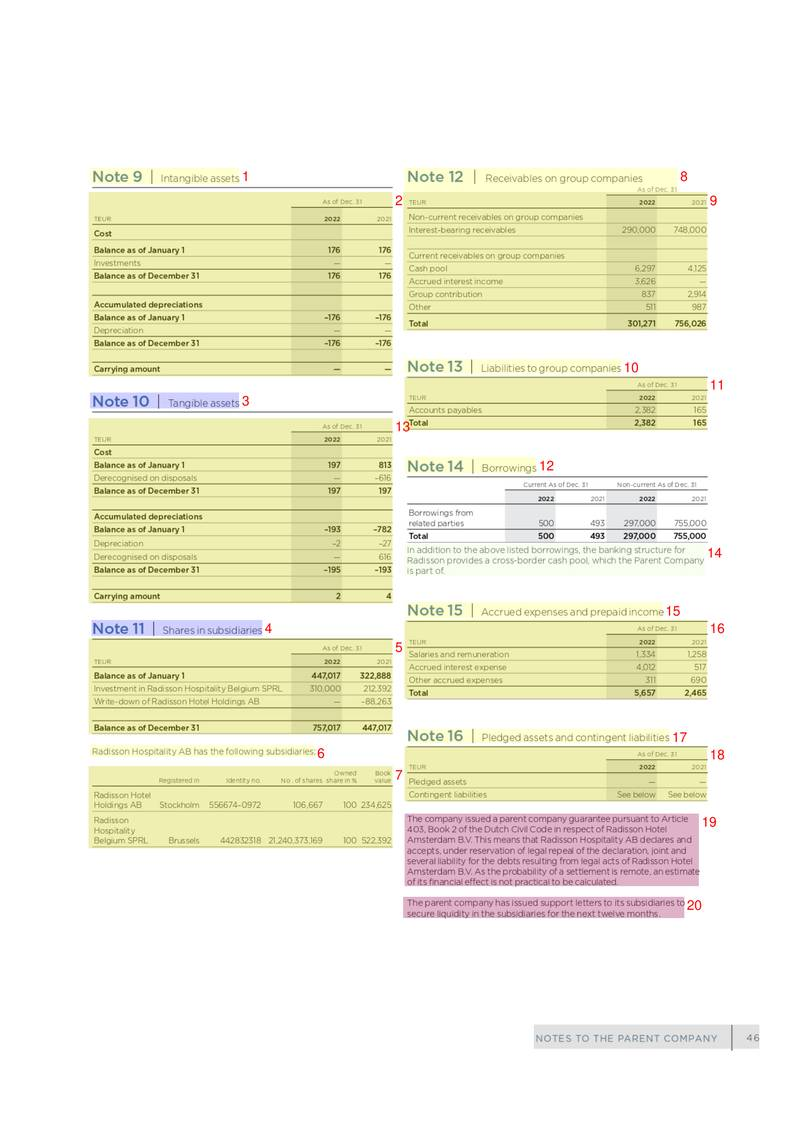

In [36]:
display_layout("./output/RHG_annual_report_2022_page-0047/RHG_annual_report_2022_page-0047_layout.pdf")

## **Example n°8**

In [37]:
! python parse.py "/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0076.jpg"

2025-06-22 09:14:52.820739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750583692.844572     720 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750583692.851590     720 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading model...
2025-06-22 09:14:56.456 | INFO     | magic_pdf.model.custom_model:__init__:26 - using configs: {'device': 'cuda', 'weights': {'doclayout_yolo': 'Structure/doclayout_yolo_docstructbench_imgsz1280_2501.pt', 'layoutreader': 'Relation'}, 'models_dir': 'model_weight', 'layout_config': {'model': 'doclayout_yolo', 'reader': {'name': 'layoutreader'}}, 'chat_config': {'weight_path': 'model_weight/Recognition', 'backend': 'lmd


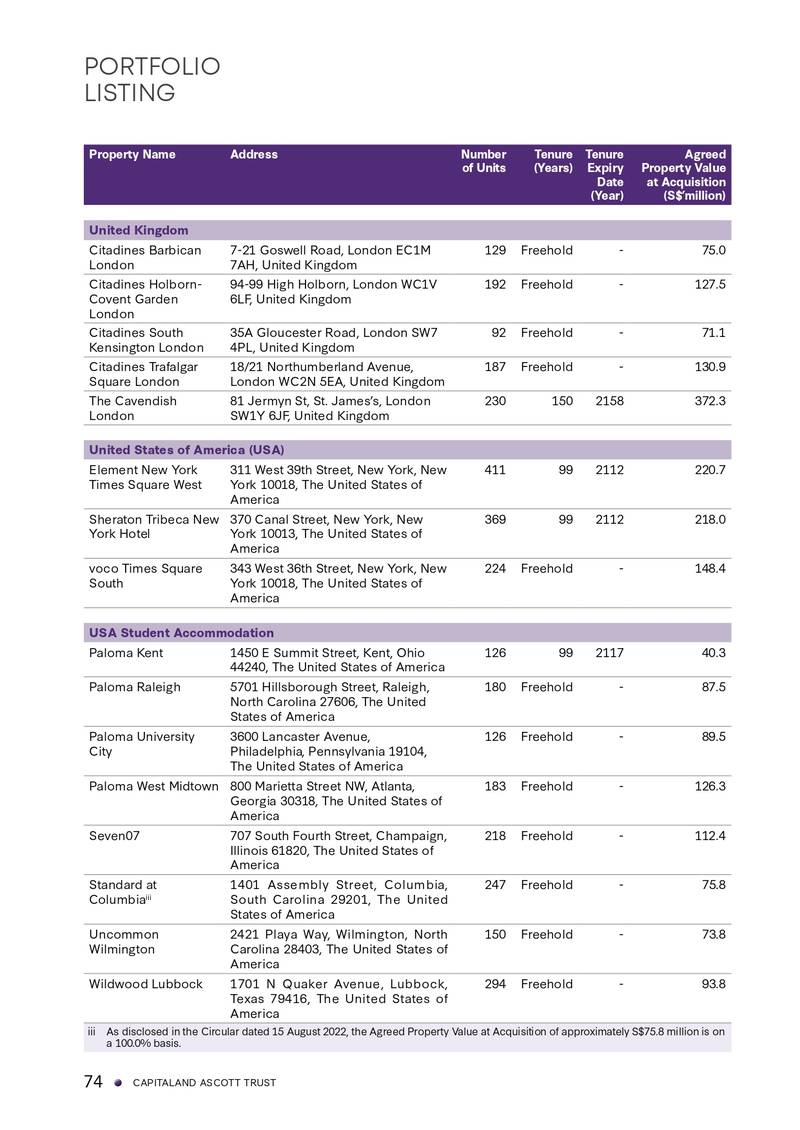

#  

<html>
----------------------------------------


Portfolio  \
                                              Listing   
                                        Property Name   
0                                      United Kingdom   
1                           Citadines Barbican London   
2              Citadines Holborn-Covent Garden London   
3                   Citadines South Kensington London   
4                   Citadines Trafalgar Square London   
5                                The Cavendish London   
6                      United States of America (USA)   
7                  Element New York Times Square West   
8                     Sheraton Tribeca New York Hotel   
9                             voco Times Square South   
10                          USA Student Accommodation   
11                                        Paloma Kent   
12                                     Paloma Raleigh   
13                             Paloma University City   
14                                Paloma West Midtown   
15                                            Seven07   
16                               Standard at Columbia   
17                                Uncommon Wilmington   
18                                   Wildwood Lubbock   
19  iii As disclosed in the Circular dated 15 Augu...   

                                                       \
                                                        
                                              Address   
0                                      United Kingdom   
1   7-21 Goswell Road, London EC1M 7AH, United Kin...   
2   94-99 High Holborn, London WC1V 6LF, United Ki...   
3   35A Gloucester Road, London SW7 4PL, United Ki...   
4   18/21 Northumberland Avenue, London WC2N 5EA, ...   
5   81 Jermyn St, St. James's, London SW1Y 6JF, Un...   
6                      United States of America (USA)   
7   311 West 39th Street, New York, New York 10018...   
8   370 Canal Street, New York, New York 10013, Th...   
9   343 West 36th Street, New York, New York 10018...   
10                          USA Student Accommodation   
11  1450 E Summit Street, Kent, Ohio 44240, The Un...   
12  5701 Hillsborough Street, Raleigh, North Carol...   
13  3600 Lancaster Avenue, Philadelphia, Pennsylva...   
14  800 Marietta Street NW, Atlanta, Georgia 30318...   
15  707 South Fourth Street, Champaign, Illinois 6...   
16  1401 Assembly Street, Columbia, South Carolina...   
17  2421 Playa Way, Wilmington, North Carolina 284...   
18  1701 N Quaker Avenue, Lubbock, Texas 79416, Th...   
19  iii As disclosed in the Circular dated 15 Augu...   

                                                       \
                                                        
                                      Number of Units   
0                                      United Kingdom   
1                                                 129   
2                                                 192   
3                                                  92   
4                                                 187   
5                                                 230   
6                      United States of America (USA)   
7                                                 411   
8                                                 369   
9                                                 224   
10                          USA Student Accommodation   
11                                                126   
12                                                180   
13                                                126   
14                                                183   
15                                                218   
16                                                247   
17                                                150   
18                                                294   
19  iii As disclosed in the Circular dated 15 Augu...   

                                                       \
                                                   

</html>


In [51]:
display_text_with_pdf_or_image_plain(
    "./output/CLAS-FY2023-AR_page-0076/CLAS-FY2023-AR_page-0076.md", 
    "/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0076.jpg"
)


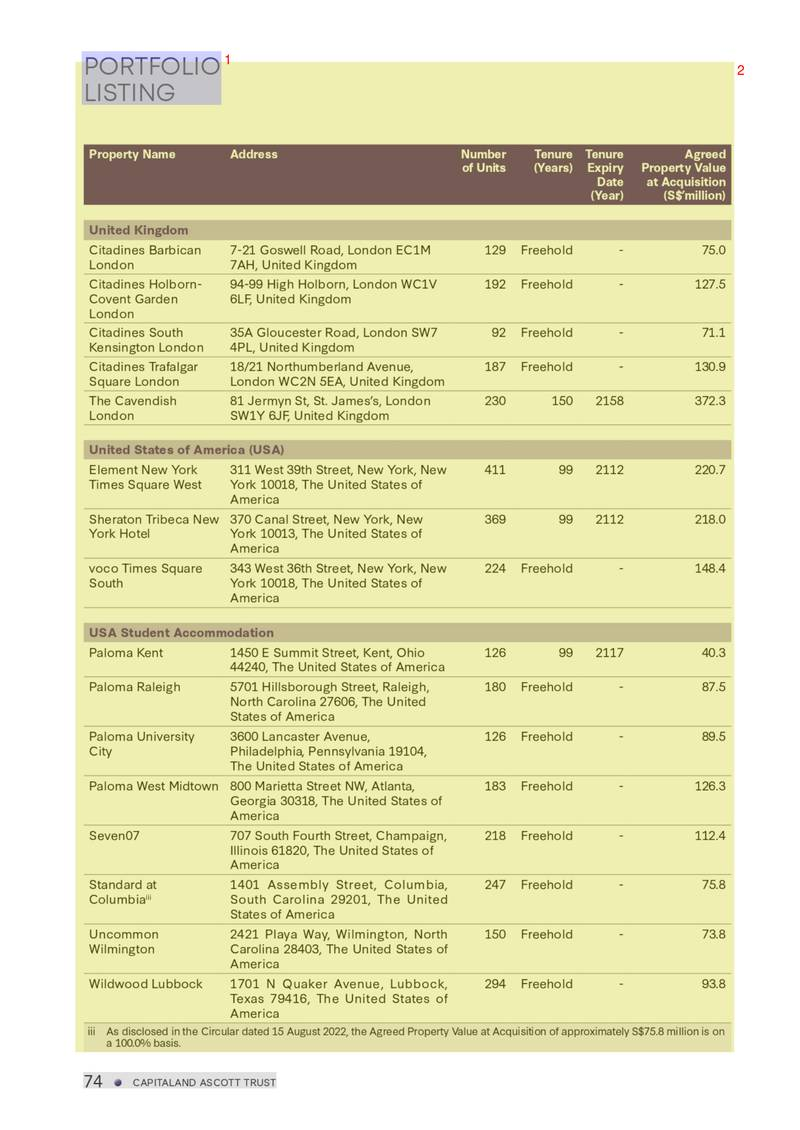

In [39]:
display_layout("./output/CLAS-FY2023-AR_page-0076/CLAS-FY2023-AR_page-0076_layout.pdf")

## **Example n°9**

In [40]:
! python parse.py "/kaggle/input/pdf-files-pages/the-full-report-pdf_page-0026.jpg"

2025-06-22 09:16:39.844070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750583799.866894     760 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750583799.874171     760 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading model...
2025-06-22 09:16:43.471 | INFO     | magic_pdf.model.custom_model:__init__:26 - using configs: {'device': 'cuda', 'weights': {'doclayout_yolo': 'Structure/doclayout_yolo_docstructbench_imgsz1280_2501.pt', 'layoutreader': 'Relation'}, 'models_dir': 'model_weight', 'layout_config': {'model': 'doclayout_yolo', 'reader': {'name': 'layoutreader'}}, 'chat_config': {'weight_path': 'model_weight/Recognition', 'backend': 'lmd


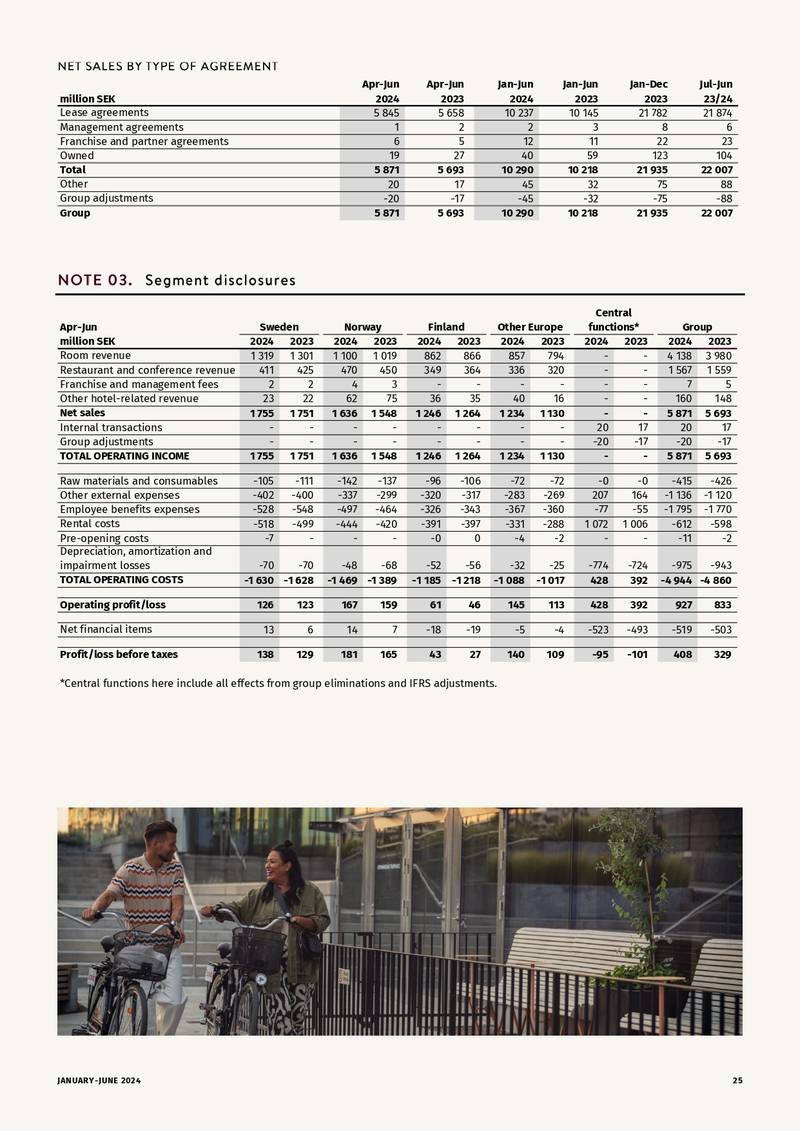

<html>
----------------------------------------


,Unnamed: 0,Apr-Jun 2024,Apr-Jun 2023,Jan-Jun 2024,Jan-Jun 2023,Jan-Dec 2023,Jul-Jun 23/24
0,Lease agreements,5 845,5 658,10 237,10 145,21 782,21 874
1,Management agreements,1,2,2,3,8,6
2,Franchise and partner agreements,6,5,12,11,22,23
3,Owned,19,27,40,59,123,104
4,Total,5 871,5 693,10 290,10 218,21 935,22 007
5,Other,20,17,45,32,75,88
6,Group adjustments,-20,-17,-45,-32,-75,-88
7,Group,5 871,5 693,10 290,10 218,21 935,22 007


</html>  

NOTE 03. Segment disclosures   


<html>
----------------------------------------


Apr-Jun million SEK  Sweden          Norway  \
                                 Apr-Jun million SEK    2024    2023    2024   
0                                       Room revenue   1 319   1 301   1 100   
1                  Restaurant and conference revenue     411     425     470   
2                      Franchise and management fees       2       2       4   
3                        Other hotel-related revenue      23      22      62   
4                                          Net sales   1 755   1 751   1 636   
5                              Internal transactions       -       -       -   
6                                  Group adjustments       -       -       -   
7                             TOTAL OPERATING INCOME   1 755   1 751   1 636   
8                      Raw materials and consumables    -105    -111    -142   
9                            Other external expenses    -402    -400    -337   
10                        Employee benefits expenses    -528    -548    -497   
11                                      Rental costs    -518    -499    -444   
12                                 Pre-opening costs      -7       -       -   
13  Depreciation, amortization and impairment losses     -70     -70     -48   
14                             TOTAL OPERATING COSTS  -1 630  -1 628  -1 469   
15                             Operating profit/loss     126     123     167   
16                               Net financial items      13       6      14   
17                          Profit/loss before taxes     138     129     181   

           Finland         Other Europe         Central functions*         \
      2023    2024    2023         2024    2023               2024   2023   
0    1 019     862     866          857     794                  -      -   
1      450     349     364          336     320                  -      -   
2        3       -       -            -       -                  -      -   
3       75      36      35           40      16                  -      -   
4    1 548   1 246   1 264        1 234   1 130                  -      -   
5        -       -       -            -       -                 20     17   
6        -       -       -            -       -                -20    -17   
7    1 548   1 246   1 264        1 234   1 130                  -      -   
8     -137     -96    -106          -72     -72                 -0     -0   
9     -299    -320    -317         -283    -269                207    164   
10    -464    -326    -343         -367    -360                -77    -55   
11    -420    -391    -397         -331    -288              1 072  1 006   
12       -      -0       0           -4      -2                  -      -   
13     -68     -52     -56          -32     -25               -774   -724   
14  -1 389  -1 185  -1 218       -1 088  -1 017                428    392   
15     159      61      46          145     113                428    392   
16       7     -18     -19           -5      -4               -523   -493   
17     165      43      27          140     109                -95   -101   

     Group          
      2024    2023  
0    4 138   3 980  
1    1 567   1 559  
2        7       5  
3      160     148  
4    5 871   5 693  
5       20      17  
6      -20     -17  
7    5 871   5 693  
8     -415    -426  
9   -1 136  -1 120  
10  -1 795  -1 770  
11    -612    -598  
12     -11      -2  
13    -975    -943  
14  -4 944  -4 860  
15     927     833  
16    -519    -503  
17     408     329

</html>

*Central functions here include all effects from group eliminations and IFRS adjustments.  

![](images/e0a1221b60633e72294b604487fb51a6a3f2491988672531aba71b82ad1ce950.jpg)


In [52]:
display_text_with_pdf_or_image_plain(
    "./output/the-full-report-pdf_page-0026/the-full-report-pdf_page-0026.md", 
    "/kaggle/input/pdf-files-pages/the-full-report-pdf_page-0026.jpg"
)


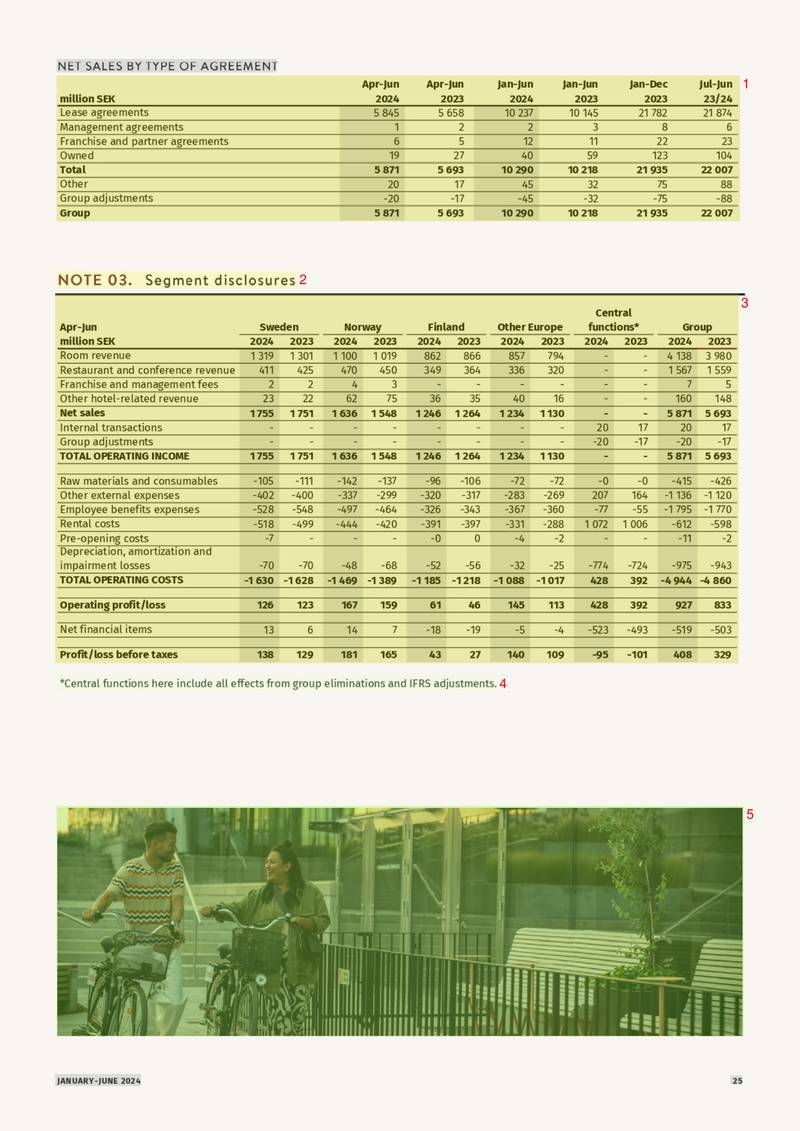

In [42]:
display_layout("./output/the-full-report-pdf_page-0026/the-full-report-pdf_page-0026_layout.pdf")

# **5. Conclusion**

<div style="background-color: red; color: white; padding: 15px; border-radius: 8px; font-size: 16px;">
  After testing MonkeyOCR on various document types, it has shown excellent performance in document parsing, layout recognition, and especially in capturing complex table structures. Overall, it performs competitively compared to other solutions.
</div>